# Assignment 6: Pytorch Segmentation
For this assignment, we're going to use Deep Learning for a new task: semantic segmentation.

## Short recap of  semantic segmentation
The goal of semantic segmentation is to classify each pixel of the image to a corresponding class of what the pixel represent. One major diference between semantic segmentation and classification is that for semantic segmentation, model output a label for each pixel instead of a single label for the whole image.

## CMP Facade Database and Visualize Samples
In this assignment, we use a new dataset named: CMP Facade Database for semantic segmentation. This dataset is made up with 606 rectified images of the facade of various buildings. The facades are from different cities arount the world with different architectural styles.

CMP Facade DB include 12 semantic classes:

* facade
* molding
* cornice
* pillar
* window
* door
* sill
* blind
* balcony
* shop
* deco
* background

In this assignment, we should use a model to classify each pixel in images to one of these 12 classes.

For more detail about CMP Facade Dataset, if you are intereseted, please check: https://cmp.felk.cvut.cz/~tylecr1/facade/

In [1]:
from google.colab import drive
drive.mount('/content/drive/') # this will mount google drive in '/content/drive/MyDrive'

import os
os.chdir('/content/drive/MyDrive/ECE176/assignment6')  # your path to assignment6 folder
!ls

!sh get_dataset.sh

Mounted at /content/drive/
assignment6.ipynb  dataset  FCN  files	get_dataset.sh	README.md
--2024-03-12 21:00:13--  https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36517004 (35M) [application/zip]
Saving to: ‘CMP_facade_DB_base.zip’

CMP_facade_DB_base. 100%[===================>]  34.83M  13.5MB/s    in 2.6s    

2024-03-12 21:00:16 (13.5 MB/s) - ‘CMP_facade_DB_base.zip’ saved [36517004/36517004]

--2024-03-12 21:00:16--  https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20309906 (19M) [application/zip]
Saving to: ‘CMP_facade_DB_extended.zip’

CMP_facade_DB_exten 10

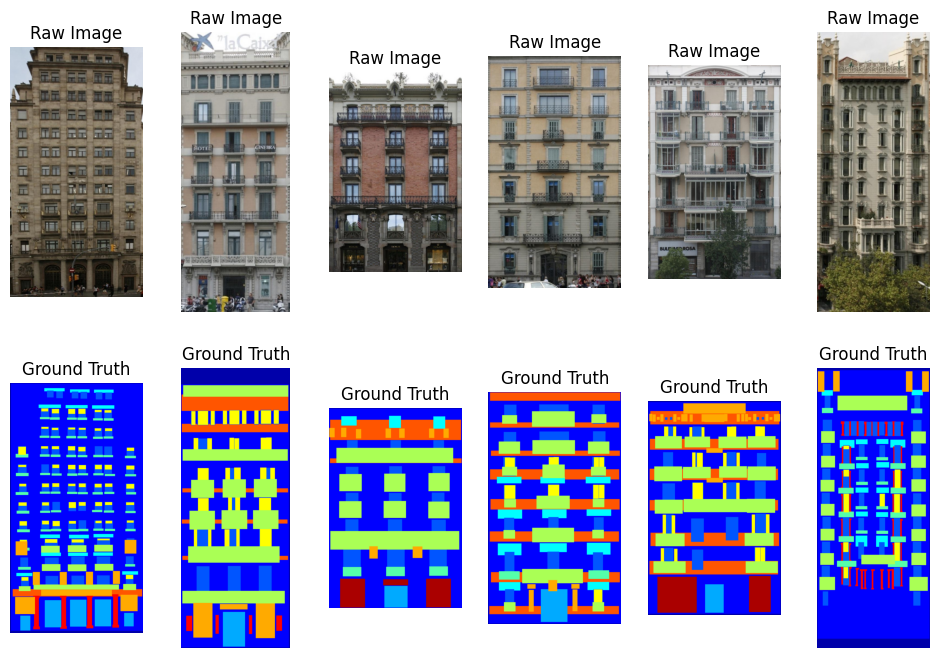

In [2]:
import matplotlib.pyplot as plt
import numpy as np

idxs = [1, 2, 5, 6, 7, 8]
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 8))
for i, idx in enumerate(idxs):
    pic = plt.imread("dataset/base/cmp_b000{}.jpg".format(idx))
    label = plt.imread("dataset/base/cmp_b000{}.png".format(idx), format="PNG")

    axes[0][i].axis('off')
    axes[0][i].imshow(pic)
    axes[0][i].set_title("Raw Image")

    axes[1][i].imshow(label)
    axes[1][i].axis('off')
    axes[1][i].set_title("Ground Truth")

## Build Dataloader and Set Up Device

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as T
import PIL
from PIL import Image
import numpy as np
import os
# import os.path as osp

from FCN.dataset import CMP_Facade_DB

os.environ["CUDA_VISIBLE_DEVICES"]="0"


def get_full_list(
    root_dir,
    base_dir="base",
    extended_dir="extended",
):
    data_list = []
    for name in [base_dir, extended_dir]:
        data_dir = os.path.join(
            root_dir, name
        )
        data_list += sorted(
            os.path.join(data_dir, img_name) for img_name in
            filter(
                lambda x: x[-4:] == '.jpg',
                os.listdir(data_dir)
            )
        )
    return data_list

TRAIN_SIZE = 500
VAL_SIZE = 30
TEST_SIZE = 70
full_data_list = get_full_list("dataset")

train_data_set = CMP_Facade_DB(full_data_list[: TRAIN_SIZE])
val_data_set = CMP_Facade_DB(full_data_list[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE])
test_data_set = CMP_Facade_DB(full_data_list[TRAIN_SIZE + VAL_SIZE:])

print("Training Set Size:", len(train_data_set))
print("Validation Set Size:", len(val_data_set))
print("Test Set Size:", len(test_data_set))

train_loader = torch.utils.data.DataLoader(
    train_data_set, batch_size=1, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_data_set, batch_size=1, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data_set, batch_size=1, shuffle=False
)



USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

Training Set Size: 500
Validation Set Size: 30
Test Set Size: 76
using device: cuda


## Fully Convolutional Networks for Semantic Segmentation

Here we are going to explore the classical work: "Fully Convolutional Networks for Semantic Segmentation"(FCN).

In FCN, the model uses the Transpose Convolution layers, which we've already learned during the lecture, to recover high resolution feature maps. For the overall introduction of Transpose Convolution and Fully Convolutional Networks, please review the lecture recording and lecture slides on Canvas(Lecture 10).

Here we do not cover all the details in FCN. Please check the original paper: https://arxiv.org/pdf/1411.4038.pdf for more details.

Besides of transpose Convolution, there are also some differences compared with the models we've been working on:

* Use 1x1 Convolution to replace fully connected layers to output score for each class.
* Use skip connection to combine high-level feature and local feature.


# Part 1: FCN-32s (30%)

In this section, we first try to implement simple version of FCN without skip connection (i.e., FCN-32s) with VGG-16 as the backbone.

Compared with VGG-16, FCN-32s
* replaces the fully connecteed layers with 1x1 convolution
* adds a Transpose Convolution at the end to output dense prediction.

Task:
1. Complete FCN-32s in the notebook as instructed.
2. Train FCN-32s for 10 epochs and record the best model. Visualize the prediction results and report the test accuracy.
3. Train FCN-32s for 20 epochs with pretrained VGG-16 weights and record the best model. Visualize the prediction results and report the test accuracy.

## 1.1 Complete the FC-32s architecture:

The following Conv use kernel size = 3, padding = 1, stride =1 (except for conv1_1 where conv1_1 should use padding = 100)

* [conv1_1(3,64)-relu] -> [conv1_2(64,64)-relu] -> [maxpool1(2,2)]
* [conv2_1(64,128)-relu] -> [conv2_2(128,128)-relu] -> [maxpool2(2,2)]
* [conv3_1(128,256)-relu] -> [conv3_2(256,256)-relu] ->[conv3_3(256,256)-relu] ->  [maxpool3(2,2)]
* [conv4_1(256,512)-relu] -> [conv4_2(512,512)-relu] ->[conv4_3(512,512)-relu] ->  [maxpool4(2,2)]
* [conv5_1(512,512)-relu] -> [conv5_2(512,512)-relu] ->[conv5_3(512,512)-relu] ->  [maxpool5(2,2)]

The following Conv use stride = 1, padding = 0 (KxK denotes kernel size, dropout probability=0.5)
* [fc6=conv7x7(512, 4096)-relu-dropout2d]
* [fc7=conv1x1(4096, 4096)-relu-dropout2d]
* [score=conv1x1(4096, num_classes)]

The transpose convolution: kernal size = 64, stride = 32, bias = False
* [transpose_conv(n_class, n_class)]

**Hint: The output of the transpose convolution might not have the same shape as the input,
    take [19: 19 + input_image_width], [19: 19 + input_image_height] for width and height dimension
    of the output to get the output with the same shape as the input**

In [10]:
class FCN32s(nn.Module):
    def __init__(self, n_class=21):
        super(FCN32s, self).__init__()
        ################################################################################
        # TODO: Implement the layers for FCN32s.                                       #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True) ## ceil_mode=False도 시도해보기!

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU()
        self.drop6 = nn.Dropout2d()

        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU()
        self.drop7 = nn.Dropout2d()

        self.score = nn.Conv2d(4096, n_class, 1)

        self.upscore = nn.ConvTranspose2d(n_class, n_class, 64, stride=32, bias=False)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        self._initialize_weights()

    def get_upsampling_weight(self, in_channels, out_channels, kernel_size):
        """Make a 2D bilinear kernel suitable for upsampling"""
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * \
               (1 - abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                          dtype=np.float64)
        weight[range(in_channels), range(out_channels), :, :] = filt
        return torch.from_numpy(weight).float()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = self.get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        ################################################################################
        # TODO: Implement the forward pass for FCN32s.                                 #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        h = x

        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score(h)

        h = self.upscore(h)

        h = h[:, :, 19:19 + x.size()[2], 19:19 + x.size()[3]].contiguous()

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return h


    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())


## 1.2  Train FCN-32s from scratch

In [11]:
from FCN.trainer import Trainer

model32 = FCN32s(n_class=12)
model32.to(device)

best_model = Trainer(
    model32,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=10
)

Init Model
Avg Acc: 0.2307, Mean IoU: 0.01922
Epochs: 0
Epoch Loss: 2.432, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 1
Epoch Loss: 2.205, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 2
Epoch Loss: 2.01, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 3
Epoch Loss: 1.946, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 4
Epoch Loss: 1.933, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 5
Epoch Loss: 1.928, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 6
Epoch Loss: 1.925, Avg Acc: 0.3432, Mean IoU: 0.02862
Epochs: 7
Epoch Loss: 1.922, Avg Acc: 0.3435, Mean IoU: 0.02876
Epochs: 8
Epoch Loss: 1.92, Avg Acc: 0.3453, Mean IoU: 0.0295
Epochs: 9
Epoch Loss: 1.918, Avg Acc: 0.3475, Mean IoU: 0.03035
Test Acc: 0.3475, Test Mean IoU: 0.03035


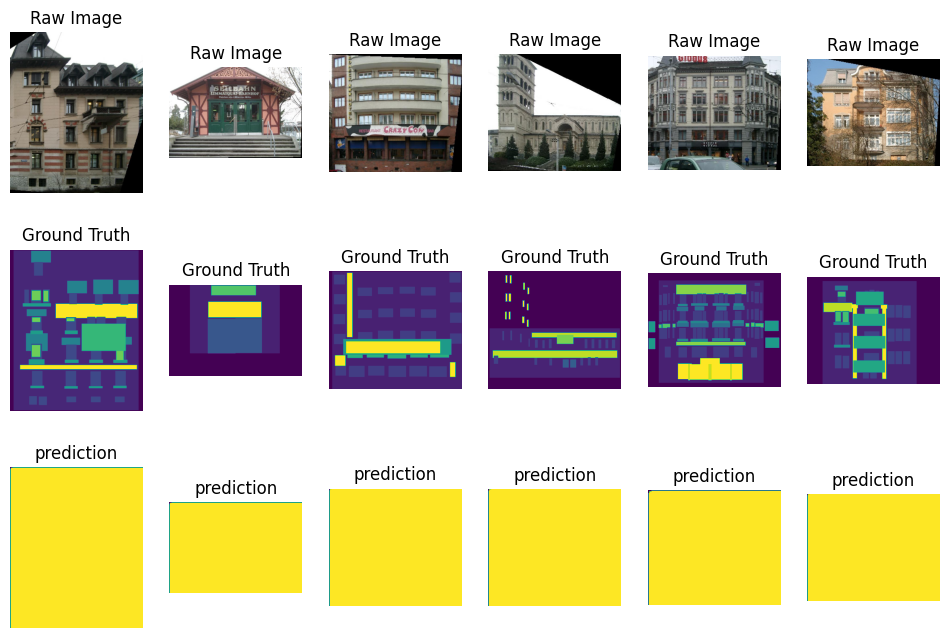

In [12]:
from FCN.trainer import visualize
visualize(best_model, test_loader)

## 1.3 Train FCN-32s with the pretrained VGG16 weights

In [13]:
import torchvision
from FCN.trainer import Trainer

vgg16 = torchvision.models.vgg16(pretrained=True)

model32_pretrain = FCN32s(n_class=12)
model32_pretrain.copy_params_from_vgg16(vgg16)
model32_pretrain.to(device)

best_model_pretrain = Trainer(
    model32_pretrain,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=20
)

Init Model
Avg Acc: 0.2307, Mean IoU: 0.01922
Epochs: 0
Epoch Loss: 1.633, Avg Acc: 0.4685, Mean IoU: 0.08571
Epochs: 1
Epoch Loss: 1.411, Avg Acc: 0.5394, Mean IoU: 0.1646
Epochs: 2
Epoch Loss: 1.295, Avg Acc: 0.5383, Mean IoU: 0.2055
Epochs: 3
Epoch Loss: 1.189, Avg Acc: 0.5525, Mean IoU: 0.2091
Epochs: 4
Epoch Loss: 1.111, Avg Acc: 0.5916, Mean IoU: 0.2595
Epochs: 5
Epoch Loss: 1.012, Avg Acc: 0.6105, Mean IoU: 0.2811
Epochs: 6
Epoch Loss: 0.9372, Avg Acc: 0.621, Mean IoU: 0.2887
Epochs: 7
Epoch Loss: 0.8662, Avg Acc: 0.6047, Mean IoU: 0.2976
Epochs: 8
Epoch Loss: 0.8103, Avg Acc: 0.6387, Mean IoU: 0.3199
Epochs: 9
Epoch Loss: 0.7653, Avg Acc: 0.6453, Mean IoU: 0.3198
Epochs: 10
Epoch Loss: 0.7228, Avg Acc: 0.6446, Mean IoU: 0.3334
Epochs: 11
Epoch Loss: 0.6837, Avg Acc: 0.6514, Mean IoU: 0.3442
Epochs: 12
Epoch Loss: 0.6496, Avg Acc: 0.6497, Mean IoU: 0.3423
Epochs: 13
Epoch Loss: 0.6279, Avg Acc: 0.6515, Mean IoU: 0.3608
Epochs: 14
Epoch Loss: 0.6055, Avg Acc: 0.6515, Mean IoU: 0.

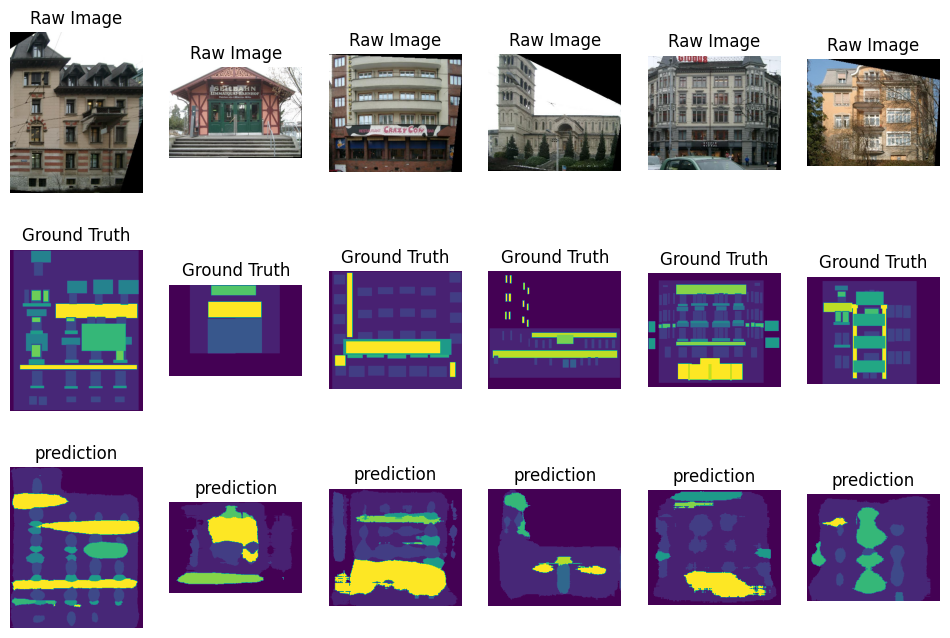

In [14]:
from FCN.trainer import visualize
visualize(best_model_pretrain, test_loader)

# Part 2: FCN-8s(40%)

In this section, we explore with another technique introduced in FCN paper: Skip Connection.

Task: Read the paper and understand the skip connection, then
1. Complete FCN-8s in the notebook as instructed.
2. Train the network for 20 epochs with pretrained VGG-16 weights and record the best model. Visualize the prediction results and report the test accuracy.

## Here we provide the structure of FCN-8s, the variant of FCN with skip connections.

FCN-8s architecture:

The following Conv use kernel size = 3, padding = 1, stride =1 (except for conv1_1 where conv1_1 should use padding = 100)

**As you can see, the structure of this part is the same as FCN-32s**

* [conv1_1(3,64)-relu] -> [conv1_2(64,64)-relu] -> [maxpool1(2,2)]
* [conv2_1(64,128)-relu] -> [conv2_2(128,128)-relu] -> [maxpool2(2,2)]
* [conv3_1(128,256)-relu] -> [conv3_2(256,256)-relu] ->[conv3_3(256,256)-relu] ->  [maxpool3(2,2)]
* [conv4_1(256,512)-relu] -> [conv4_2(512,512)-relu] ->[conv4_3(512,512)-relu] ->  [maxpool4(2,2)]
* [conv5_1(512,512)-relu] -> [conv5_2(512,512)-relu] ->[conv5_3(512,512)-relu] ->  [maxpool5(2,2)]

The following Conv use stride = 1, padding = 0 (KxK denotes kernel size, dropout probability=0.5)
* [fc6=conv7x7(512, 4096)-relu-dropout2d]
* [fc7=conv1x1(4096, 4096)-relu-dropout2d]
* [score=conv1x1(4096, num_classes)]

The Additional Score Pool use kernel size = 1, stride = 1, padding = 0
* [score_pool_3 =conv1x1(256, num_classes)]
* [score_pool_4 =conv1x1(512, num_classes)]

The transpose convolution: kernal size = 4, stride = 2, bias = False
* [upscore1 = transpose_conv(n_class, n_class)]

The transpose convolution: kernal size = 4, stride = 2, bias = False
* [upscore2 = transpose_conv(n_class, n_class)]

The transpose convolution: kernal size = 16, stride = 8, bias = False
* [upscore3 = transpose_conv(n_class, n_class)]


Different from FCN-32s which has only single path from input to output, there are multiple data path from input to output in FCN-8s.

The following graph is from original FCN paper, you can also find the graph there.

!["Architecture Graph"](files/arch.png)
"Layers are shown as grids that reveal relative spatial coarseness. Only pooling and prediction layers are shown; intermediate convolution layers (including converted fully connected layers) are omitted. " ---- FCN

Detailed path specification:

* score_pool_3
    * input: output from layer "pool3"
    * take [9: 9 + upscore2_width], [9: 9 + upscore2_height]
    
* score_pool_4,
    * input: output from layer "pool4"
    * take [5: 5 + upscore1_width], [5: 5 + upscore1_height]


* upscore1
    * input: output from layer "score"

* upscore2:
    * input: output from layer "score_pool_4" + output from layer "upscore1"

* upscore3:
    * input: output from layer "score_pool_3" + output from layer "upscore2"
    * take [31: 31 + input_image_width], [31: 31 + input_image_height]


In [7]:
import torch.nn as nn

class FCN8s(nn.Module):

    def __init__(self, n_class=12):
        super(FCN8s, self).__init__()

        ################################################################################
        # TODO: Implement the layers for FCN8s.                                        #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, stride=2) ## ceil_mode=True/False?

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(2, stride=2)

        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU()
        self.drop6 = nn.Dropout2d()

        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU()
        self.drop7 = nn.Dropout2d()

        self.score = nn.Conv2d(4096, n_class, 1)

        self.score_pool_3 = nn.Conv2d(256, n_class, 1)

        self.score_pool_4 = nn.Conv2d(512, n_class, 1)

        self.upscore1 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, bias=False)

        self.upscore2 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, bias=False)

        self.upscore3 = nn.ConvTranspose2d(n_class, n_class, 16, stride=8, bias=False)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        self._initialize_weights()

    def get_upsampling_weight(self, in_channels, out_channels, kernel_size):
        """Make a 2D bilinear kernel suitable for upsampling"""
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * \
               (1 - abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                          dtype=np.float64)
        weight[range(in_channels), range(out_channels), :, :] = filt
        return torch.from_numpy(weight).float()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = self.get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)


    def forward(self, x):
        ################################################################################
        # TODO: Implement the forward pass for FCN8s.                                 #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        h = x
        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)
        pool3 = h

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)
        pool4 = h

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score(h)
        score = h

        # upscore1
        h = score
        h = self.upscore1(h)
        output_upscore1 = h

        # score_pool_4
        h = pool4
        h = self.score_pool_4(h)
        h = h[:, :, 5:5 + output_upscore1.size()[2], 5:5 + output_upscore1.size()[3]]
        output_score_pool_4 = h

        # upscore2
        h = output_score_pool_4 + output_upscore1
        h = self.upscore2(h)
        # print(h.size()) # torch.Size([1, 12, 156, 188])
        output_upscore2 = h

        # score_pool_3
        h = pool3
        h = self.score_pool_3(h)
        # print(h.size()) # torch.Size([1, 12, 57, 68])
        h = h[:, :, 9:9 + output_upscore2.size()[2], 9:9 + output_upscore2.size()[3]]
        # print(h.size()) # torch.Size([1, 12, 48, 59])
        output_score_pool_3 = h

        # upscore3
        # print("output_score_pool_3 size: ", output_score_pool_3.size()) # torch.Size([1, 12, 48, 59])
        # print("output_upscore2 size: ", output_upscore2.size()) # torch.Size([1, 12, 156, 188])
        h = output_score_pool_3 + output_upscore2
        h = self.upscore3(h)
        h = h[:, :, 31:31 + x.size()[2], 31:31 + x.size()[3]].contiguous()

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return h

    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data.copy_(l1.weight.data)
                l2.bias.data.copy_(l1.bias.data)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))


In [8]:
from FCN.trainer import Trainer
import torchvision

vgg16 = torchvision.models.vgg16(pretrained=True)

model8 = FCN8s(n_class=12)
model8.copy_params_from_vgg16(vgg16)
model8.to(device)

best_model_fcn8s = Trainer(
    model8,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=20
)

Init Model
Avg Acc: 0.2307, Mean IoU: 0.01922
Epochs: 0
Epoch Loss: 1.17, Avg Acc: 0.5933, Mean IoU: 0.3209
Epochs: 1
Epoch Loss: 0.9493, Avg Acc: 0.6512, Mean IoU: 0.3626
Epochs: 2
Epoch Loss: 0.8461, Avg Acc: 0.6743, Mean IoU: 0.3886
Epochs: 3
Epoch Loss: 0.7807, Avg Acc: 0.6748, Mean IoU: 0.4055
Epochs: 4
Epoch Loss: 0.7156, Avg Acc: 0.6994, Mean IoU: 0.4111
Epochs: 5
Epoch Loss: 0.6631, Avg Acc: 0.7082, Mean IoU: 0.4461
Epochs: 6
Epoch Loss: 0.5965, Avg Acc: 0.7231, Mean IoU: 0.4321
Epochs: 7
Epoch Loss: 0.5548, Avg Acc: 0.7215, Mean IoU: 0.4407
Epochs: 8
Epoch Loss: 0.5072, Avg Acc: 0.7148, Mean IoU: 0.4419
Epochs: 9
Epoch Loss: 0.4716, Avg Acc: 0.7052, Mean IoU: 0.4164
Epochs: 10
Epoch Loss: 0.44, Avg Acc: 0.7301, Mean IoU: 0.4761
Epochs: 11
Epoch Loss: 0.4055, Avg Acc: 0.7285, Mean IoU: 0.4595
Epochs: 12
Epoch Loss: 0.3873, Avg Acc: 0.732, Mean IoU: 0.4657
Epochs: 13
Epoch Loss: 0.3672, Avg Acc: 0.7282, Mean IoU: 0.458
Epochs: 14
Epoch Loss: 0.3609, Avg Acc: 0.7275, Mean IoU: 0.

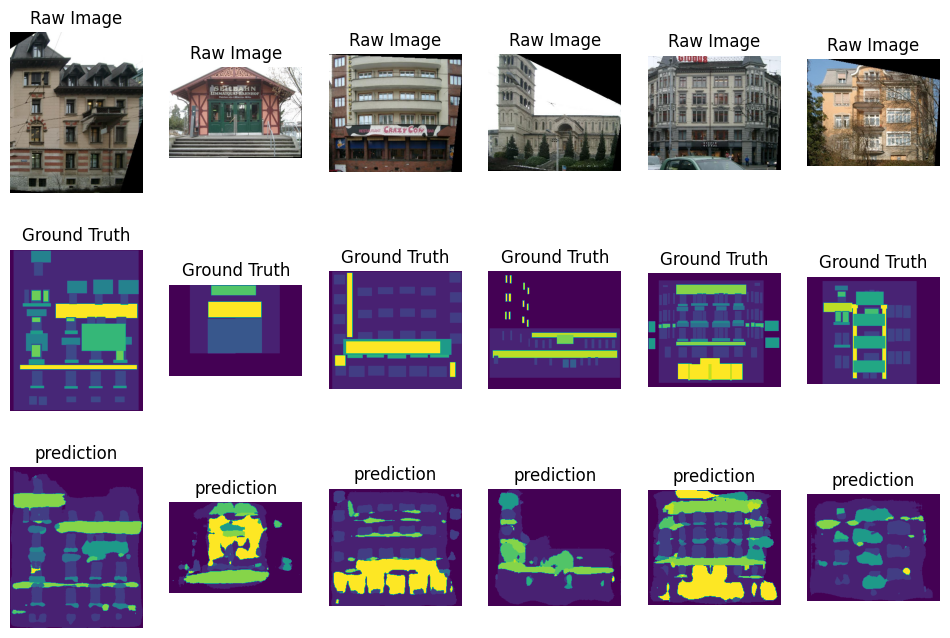

In [9]:
from FCN.trainer import visualize
visualize(best_model_fcn8s, test_loader)

# Part 3:  Questions (29%):

#### Question 1: Compare the FCN-32s training from scratch with the FCN-32s with pretrained weights? What do you observe? Does pretrained weights help? Why? Please be as specific as possible.

### Your Answer:

We can observe that pretrained weight help the model better segment the image while model with scratch can barely segment features. Pretrained model normally contain useful features which were trained in huge datasets. 

1. Those features capture ordinary features which help when working with new data. 

2. In addition, if we train the model from scratch, sometimes overfitting might occur when we don't have enough dataset. This case, pretrained model might work well because it can use the data used when training. 

3. Besides, FCN-32s with pretrained weights took less time compared to the FCN-32s training from scratch.

#### Question 2: Compare the performance and visualization of FCN-32s and FCN-8s (both with pretrained weights). What do you observe? Which performs better? Why? Please be as specific as possible.

### Your Answer:

FCN-8s performs better than FCN-32s. We can observe that FCN-32s can segment big portion of each segment while FCN-8s can even segment more precise portion of each segment. The reason can be described as below.

1. FCN-8s uses skip connection which combine features with respect to different resolution. This helps the model to consider both the high-resolution information and low-resolution information.

2. FCN-8s can perform more precise upsampling because FCN-32s performs x32 upsampling at once while FCN-8s performs smaller upsampling each step.

3. FCN-8s can reflect middle layer features therefore lead to using more context information.

## Survey (1%)

### Question:

How many hours did you spend on this assignment?

### Your Answer:

10 hours